In [1]:
#Loading all packages into python
import os
import csv
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score

In [4]:
#Reading csv file and save into dataframe.
originaldf = pd.read_csv('Ecommerce_Customers.csv', sep=',')
df = originaldf.drop(['Email','Address','Avatar'], axis = 1) #removing unecessary data

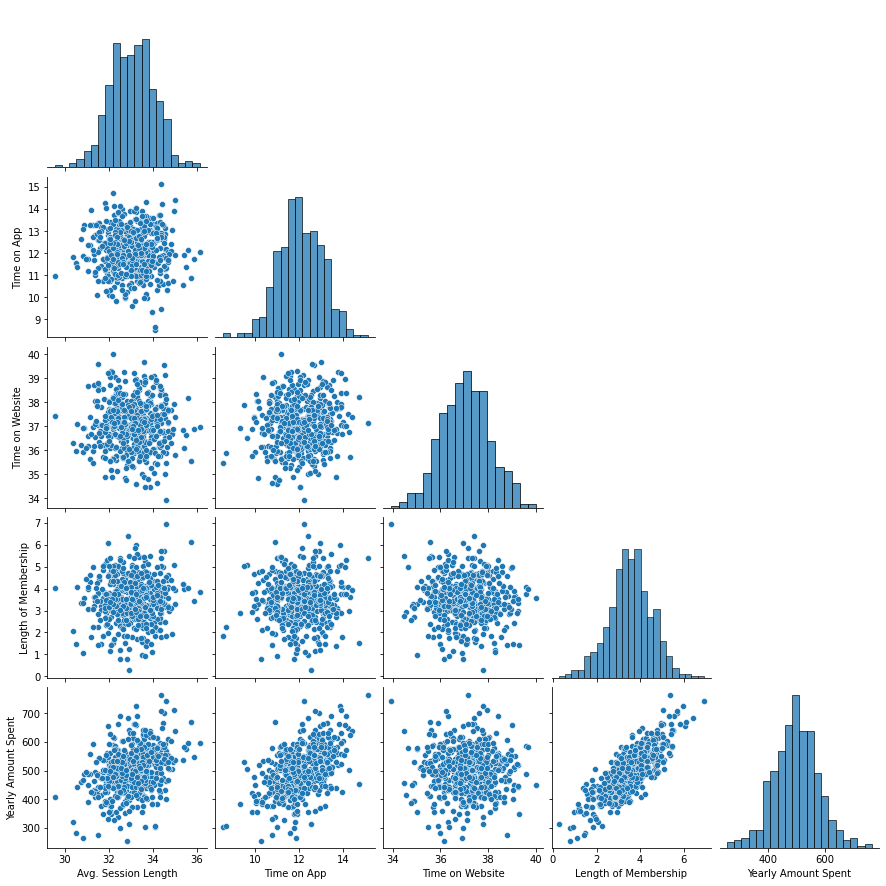

In [5]:
#plotting pairplot of the numerican data
sns.pairplot(df,corner=True)

In [6]:
#Check data summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Avg. Session Length   500 non-null    float64
 1   Time on App           500 non-null    float64
 2   Time on Website       500 non-null    float64
 3   Length of Membership  500 non-null    float64
 4   Yearly Amount Spent   500 non-null    float64
dtypes: float64(5)
memory usage: 19.7 KB


In [7]:
#Check data summary
df.describe()

,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,33.053194,12.052488,37.060445,3.533462,499.314038
std,0.992563,0.994216,1.010489,0.999278,79.314782
min,29.532429,8.508152,33.913847,0.269901,256.670582
25%,32.341822,11.388153,36.349257,2.930450,445.038277
50%,33.082008,11.983231,37.069367,3.533975,498.887875
75%,33.711985,12.753850,37.716432,4.126502,549.313828
max,36.139662,15.126994,40.005182,6.922689,765.518462


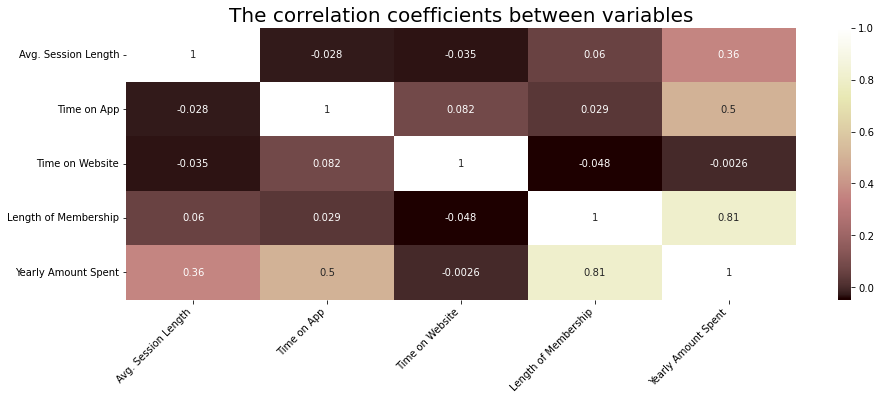

In [9]:
#Plotting correlation coefficients of variables using seaborn heatmap
cor_matrix = df.corr()
plt.figure(figsize = (15,5))
ax = sns.heatmap(cor_matrix, annot=True, cmap = 'pink')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('The correlation coefficients between variables', fontsize=20)
plt.show()

In [11]:
#Normality test and save into dataframe
statistics = []
shapiro_results = []
for i in df.columns: 
    a,b = shapiro(df[[i]])
    if b < 0.5:
        result = "Rejected"
    else:
        result = "Not rejected"
    statistics.append(["Statistics", round(a,3), "p-value", round(b,2)])
    shapiro_results.append(result)

print(*list(zip(df.columns, statistics, shapiro_results)), sep="\n")

normalitytest = pd.DataFrame(statistics)
normalitytest.set_index(df.columns)

('Avg. Session Length', ['Statistics', 0.998, 'p-value', 0.72], 'Not rejected')
('Time on App', ['Statistics', 0.997, 'p-value', 0.55], 'Not rejected')
('Time on Website', ['Statistics', 0.998, 'p-value', 0.94], 'Not rejected')
('Length of Membership', ['Statistics', 0.996, 'p-value', 0.27], 'Rejected')
('Yearly Amount Spent', ['Statistics', 0.996, 'p-value', 0.26], 'Rejected')


,0,1,2,3
Avg. Session Length,Statistics,0.998,p-value,0.72
Time on App,Statistics,0.997,p-value,0.55
Time on Website,Statistics,0.998,p-value,0.94
Length of Membership,Statistics,0.996,p-value,0.27
Yearly Amount Spent,Statistics,0.996,p-value,0.26


In [12]:
#Divide the data into xvariables and yvariable for linear regression model
linearx = df.iloc[:,:-1]
lineary = df['Yearly Amount Spent']

#Split data into train/test dataset
linear_x_train, linear_x_test, linear_y_train, linear_y_test = train_test_split(linearx,lineary,test_size=0.25)

#Fitting linear model on train-data
LinearReg = LinearRegression()
Linearmodel = LinearReg.fit(linear_x_train,linear_y_train)

#Checking intercept and coefficients of fitted model
Coef = Linearmodel.coef_
Intercept = Linearmodel.intercept_
Linearmodel_list = [Intercept]+list(Coef)
Linear_model = pd.DataFrame(Linearmodel_list, index = ["Intercept", "Avg Session Length", "Time on App", "Time on Website",'Length of Membership'],columns=["Linear Model"])
Linear_model

,Linear Model
Intercept,-1067.431954
Avg Session Length,25.670839
Time on App,38.500321
Time on Website,0.965142
Length of Membership,61.763749


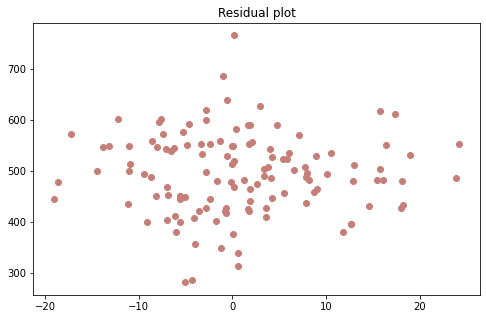

In [15]:
#Checking residual plot
linear_y_predict = Linearmodel.predict(linear_x_test)
residuals = linear_y_test-linear_y_predict

plt.figure(figsize = (8,5))
plt.scatter(residuals,linear_y_predict,color="#C57F78")
plt.title("Residual plot")
plt.show()

In [16]:
#Save R-squared and Mean-Squared-Error for fitted linear value
r2 = Linearmodel.score(linear_x_test, linear_y_test)
mse = mean_squared_error(linear_y_test, linear_y_predict)

#Cross-validation
cv = KFold(n_splits=10, random_state=1, shuffle=True)
score=cross_val_score(Linearmodel, linearx,lineary,cv=cv)
cv_r2 = score.mean()
scoring = "neg_mean_squared_error"
cv_mses= (-cross_val_score(Linearmodel, linearx, lineary, scoring=scoring, cv=cv))
cv_mse = cv_mses.mean()

In [17]:
#Result of different between 80/20 split model and cross-validation model
Normsplit_result = [r2, mse]
Cv_result = [cv_r2, cv_mse]
diff = np.array(Normsplit_result)-np.array(Cv_result)
result_list = [Normsplit_result,Cv_result,diff]

comp = pd.DataFrame(result_list, columns = ['R-squared', 'Mean Sqaured Error'], index=['Normsplit Result','Cv Result', 'Difference'])
comp

,R-squared,Mean Sqaured Error
Normsplit Result,0.98734,78.774039
Cv Result,0.98264,100.524567
Difference,0.00470,-21.750527


In [18]:
#Predicting year amount of spent for new incoming customer data
new_customer1 = ([[35,15,30,2]])
new_customer2 = ([[40,20,20,4]])
New_customer_yearly_spent_amount1 = int(Linearmodel.predict(new_customer1))
New_customer_yearly_spent_amount2 = int(Linearmodel.predict(new_customer2))
print("This customer's year spent amount is most likely $" + str(New_customer_yearly_spent_amount1))
print("This customer's year spent amount is most likely $" + str(New_customer_yearly_spent_amount2))

This customer's year spent amount is most likely $561
This customer's year spent amount is most likely $995


C:\Users\Eunji\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Eunji\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [19]:
#Divide the customer into 2 groups('VIP':1, 'Regular':0) based one mean value of yearly amount spent
df['Classification'] = np.where(df['Yearly Amount Spent'] > 499, 1, 0)
df

,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent,Classification
0,34.497268,12.655651,39.577668,4.082621,587.951054,1
1,31.926272,11.109461,37.268959,2.664034,392.204933,0
2,33.000915,11.330278,37.110597,4.104543,487.547505,0
3,34.305557,13.717514,36.721283,3.120179,581.852344,1
4,33.330673,12.795189,37.536653,4.446308,599.406092,1
...,...,...,...,...,...,...
495,33.237660,13.566160,36.417985,3.746573,573.847438,1
496,34.702529,11.695736,37.190268,3.576526,529.049004,1
497,32.646777,11.499409,38.332576,4.958264,551.620146,1
498,33.322501,12.391423,36.840086,2.336485,456.469510,0


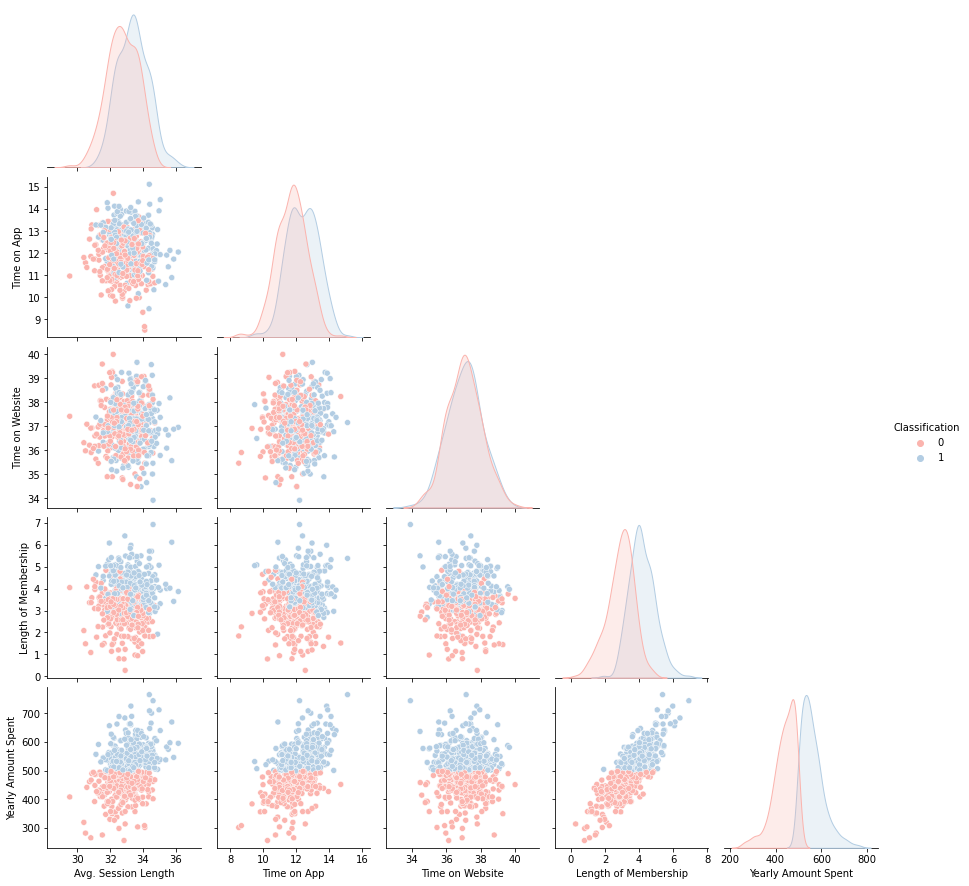

In [30]:
#Pairplot for each class
sns.pairplot(df, hue="Classification", corner = True, palette='Pastel1')

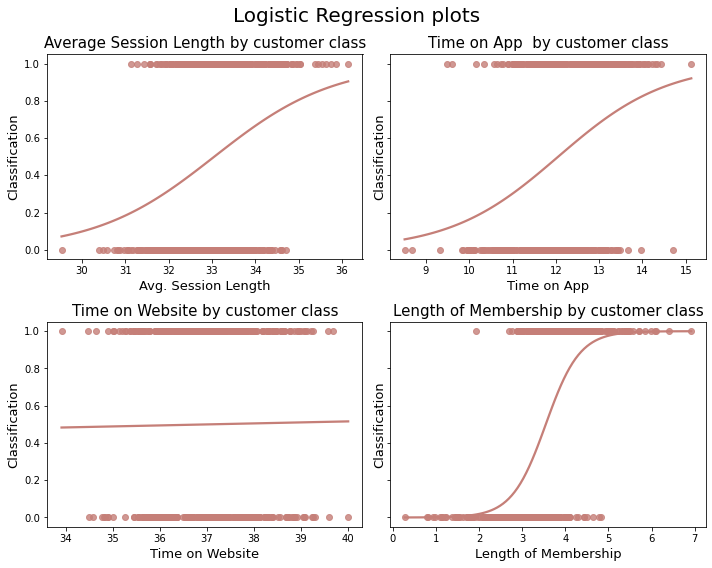

In [24]:
#Logistic regresson plots by variables
y = df['Classification']
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
fig.suptitle('Logistic Regression plots', fontsize=20)

sns.regplot(ax=axes[0,0], x=df['Avg. Session Length'], y=y, data=df, logistic=True, ci=0.95 ,color = '#C57F78')
axes[0, 0].set_title('Average Session Length by customer class', fontsize=15)
axes[0, 0].set_xlabel('Avg. Session Length', fontsize=13)
axes[0, 0].set_ylabel('Classification', fontsize=13)

sns.regplot(ax=axes[0,1], x=df['Time on App'], y=y, data=df, logistic=True, ci=0.95,color = '#C57F78')
axes[0,1].set_title('Time on App  by customer class', fontsize=15)
axes[0,1].set_xlabel('Time on App', fontsize=13)
axes[0,1].set_ylabel('Classification', fontsize=13)

sns.regplot(ax=axes[1,0], x=df['Time on Website'], y=y, data=df, logistic=True, ci=0.95,color = '#C57F78')
axes[1,0].set_title('Time on Website by customer class', fontsize=15)
axes[1,0].set_xlabel('Time on Website', fontsize=13)
axes[1,0].set_ylabel('Classification', fontsize=13)

sns.regplot(ax=axes[1,1], x=df['Length of Membership'], y=y, data=df, logistic=True, ci=0.95,color = '#C57F78')
axes[1,1].set_title('Length of Membership by customer class', fontsize=15)
axes[1,1].set_xlabel('Length of Membership', fontsize=13)
axes[1,1].set_ylabel('Classification', fontsize=13)
fig.tight_layout()
fig.savefig('Logistic Regression Plots.png', dpi=1200)
plt.show()


In [25]:
#Dividing the data into x,y for logistic regression
logistic_x = df.iloc[:,:-2]
logistic_y = df['Classification']
logistic_xtrain, logistic_xtest, logistic_ytrain, logistic_ytest = train_test_split(logistic_x,logistic_y,test_size=0.25)

In [26]:
#Fitting logistic regression and check the model accuracy
logistic_model = LogisticRegression()
logistic_model.fit(logistic_xtrain, logistic_ytrain)

logistic_train_accuracy = logistic_model.score(logistic_xtrain, logistic_ytrain)
prediction = logistic_model.predict(logistic_xtest)

print(confusion_matrix(logistic_ytest, prediction))
print(classification_report(logistic_ytest, prediction))

[[54  0]
 [ 4 67]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        54
           1       1.00      0.94      0.97        71

    accuracy                           0.97       125
   macro avg       0.97      0.97      0.97       125
weighted avg       0.97      0.97      0.97       125



In [27]:
#predicting the yearly amount spent and customer class with new given data. 
new_customer_example = np.array([30, 15.265884, 35, 4.5]).reshape(1,-1)

spent_prediction = Linearmodel.predict(new_customer_example)
class_prediction = logistic_model.predict(new_customer_example)

print("This customer is most likely will spend $"+str(int(spent_prediction))+" yearly")
print ("This customer is class",'VIP' if class_prediction == 1 else 'Normal')


This customer is most likely will spend $602 yearly
This customer is class VIP


C:\Users\Eunji\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Eunji\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
